In [2]:
from whobpyt.datatypes import par
from whobpyt.models.RWWABT import RNNRWWABT, ParamsRWWABT
from whobpyt.optimization.custom_cost_RWW import CostsRWW
from whobpyt.run import Model_fitting
from sklearn.model_selection import train_test_split

# array and pd stuff
import numpy as np
import pandas as pd
from scipy.io import loadmat # for reading in the .mat files
import torch
import json

# viz stuff
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_avg_fc(fcs):
    corr_matrices = []

    for data in fcs:
        fc = np.corrcoef(data.T)
        corr_matrices.append(fc)

    stacked_corr = np.stack(corr_matrices, axis = 0)
    avg_corr = np.mean(stacked_corr, axis =0)
    
    return avg_corr

In [3]:
def get_avg_fmr(fmris):
    stacked_corr = np.stack(fmris, axis = 0)
    avg_corr = np.mean(stacked_corr, axis =0)
    
    return avg_corr

In [4]:
# %%
# load raw data and get SC empirical BOLD and FC

sc = np.genfromtxt('../data/DTI_fiber_consensus_HCP.csv', delimiter=',')

patients = pd.read_csv('../data/ADNIMERGE/ADNIMERGE_29Apr2024_wFiles.csv')
pgroup = 'MCI'

if pgroup == 'MCI':
    patients = patients[patients['DX_bl'].isin(['EMCI', 'LMCI'])]
else:    
    patients = patients[patients['DX_bl'] == pgroup]

fcs = []

for file in patients['FC_DATA']:
    fc = loadmat(f'../{file}')
    fc = fc['ROI_activity'][:100, :]
    if fc.shape[1] == 197:
        fc = fc.T
        fcs.append(fc)

print(len(fcs))

# normalise all fcs - zscore
for i, fc in enumerate(fcs):
    fcs[i] = (fc - fc.mean(axis=0)) / fc.std(axis=0)

train_data, test_data = train_test_split(fcs, test_size=0.2, random_state=42)

print('Training set: ', len(train_data))
print('Test set: ', len(test_data))

203
Training set:  162
Test set:  41


In [5]:
# define options for wong-wang model
node_size = 100
mask = np.tril_indices(node_size, -1)
num_epochs = 50
TPperWindow = 20
step_size = 0.1
tr = 0.75
repeat_size = 5
ts_length = fcs[0].shape[0]


In [6]:
SC = (sc + sc.T) * 0.5
sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))

fc_emp_train = get_avg_fc(train_data)
fc_emp_test = get_avg_fc(test_data)

In [7]:
pgroup

'MCI'

In [13]:
# Get the optimal params from tuning files

with open(f'../data/optuna_trials/optuna_{pgroup}_study_2.json') as file:
    hyperparams = json.load(file)
    print(hyperparams)
    
    hyperparams = hyperparams['params']
    
    bAB_E = hyperparams['bAB_E']
    sAB_E = hyperparams['sAB_E']
    bt_E = hyperparams['bt_E']
    st_E = hyperparams['st_E']
    bAB_I = hyperparams['bAB_I']
    sAB_I = hyperparams['sAB_I']
    lr = hyperparams['learning_rate']
    sp_threshold = hyperparams['softplus_threshold']

{'params': {'learning_rate': 0.05, 'bAB_E': -1.026687315701573, 'sAB_E': 3.4427744183767133, 'bt_E': -0.1555155350316908, 'st_E': -1.2906392601169514, 'bAB_I': -3.2613885265888074, 'sAB_I': -2.6305870917421164, 'softplus_threshold': 88}, 'score': 0.6584159940152984}


In [14]:
params = ParamsRWWABT(bAB_E=par(val=bAB_E, fit_par=True), sAB_E=par(val=sAB_E, fit_par=True), bt_E=par(val=bt_E, fit_par=True),
                      st_E=par(val=st_E, fit_par=True), bAB_I=par(val=bAB_I, fit_par=True), sAB_I=par(val=sAB_I, fit_par=True))

abeta_file = np.genfromtxt(f'../data/avg_scans/AB_{pgroup}.csv', delimiter=",")
abeta = torch.tensor(abeta_file, dtype=torch.float32)

tau_file = np.genfromtxt(f'../data/avg_scans/TAU_{pgroup}.csv', delimiter=",")
tau = torch.tensor(tau_file, dtype=torch.float32)

model = RNNRWWABT(node_size, TPperWindow, step_size, repeat_size, tr, sc, abeta, tau, True, params)

# %%
# create objective function
ObjFun = CostsRWW(model)

# %%
# call model fit
F = Model_fitting(model, ObjFun)

In [15]:
# Model Training
# ---------------------------------------------------
#
F.train(u = 0, empFcs = [torch.from_numpy(fc_emp_train)], num_epochs = num_epochs, 
        num_windows = int(ts_length / TPperWindow), learningrate = lr, early_stopping=True, softplus_threshold = sp_threshold)

epoch:  0 Pseudo FC_cor:  0.03993465107494667
loss: 14.649701814434215
epoch:  1 Pseudo FC_cor:  0.022675063342477472
loss: 10.51648240855507
epoch:  2 Pseudo FC_cor:  0.06281773112846734
loss: 9.726228317383109
epoch:  3 Pseudo FC_cor:  0.05782205204452699
loss: 9.966177187113878
epoch:  4 Pseudo FC_cor:  0.10020871402916247
loss: 9.790312423307975
epoch:  5 Pseudo FC_cor:  0.10310624049552532
loss: 9.830475063527249
epoch:  6 Pseudo FC_cor:  0.1799547708373434
loss: 9.502799125209343
epoch:  7 Pseudo FC_cor:  0.1265263624750429
loss: 9.384327812850886
epoch:  8 Pseudo FC_cor:  0.20090540933841036
loss: 9.372613042457896
epoch:  9 Pseudo FC_cor:  0.17805935084039734
loss: 9.37031044582145
epoch:  10 Pseudo FC_cor:  0.233343000521429
loss: 9.306531528827577
epoch:  11 Pseudo FC_cor:  0.3389703011424408
loss: 8.888458213944538
epoch:  12 Pseudo FC_cor:  0.3087721222725579
loss: 8.734070271369161
epoch:  13 Pseudo FC_cor:  0.3578375675850125
loss: 8.71333661644701
epoch:  14 Pseudo FC_co

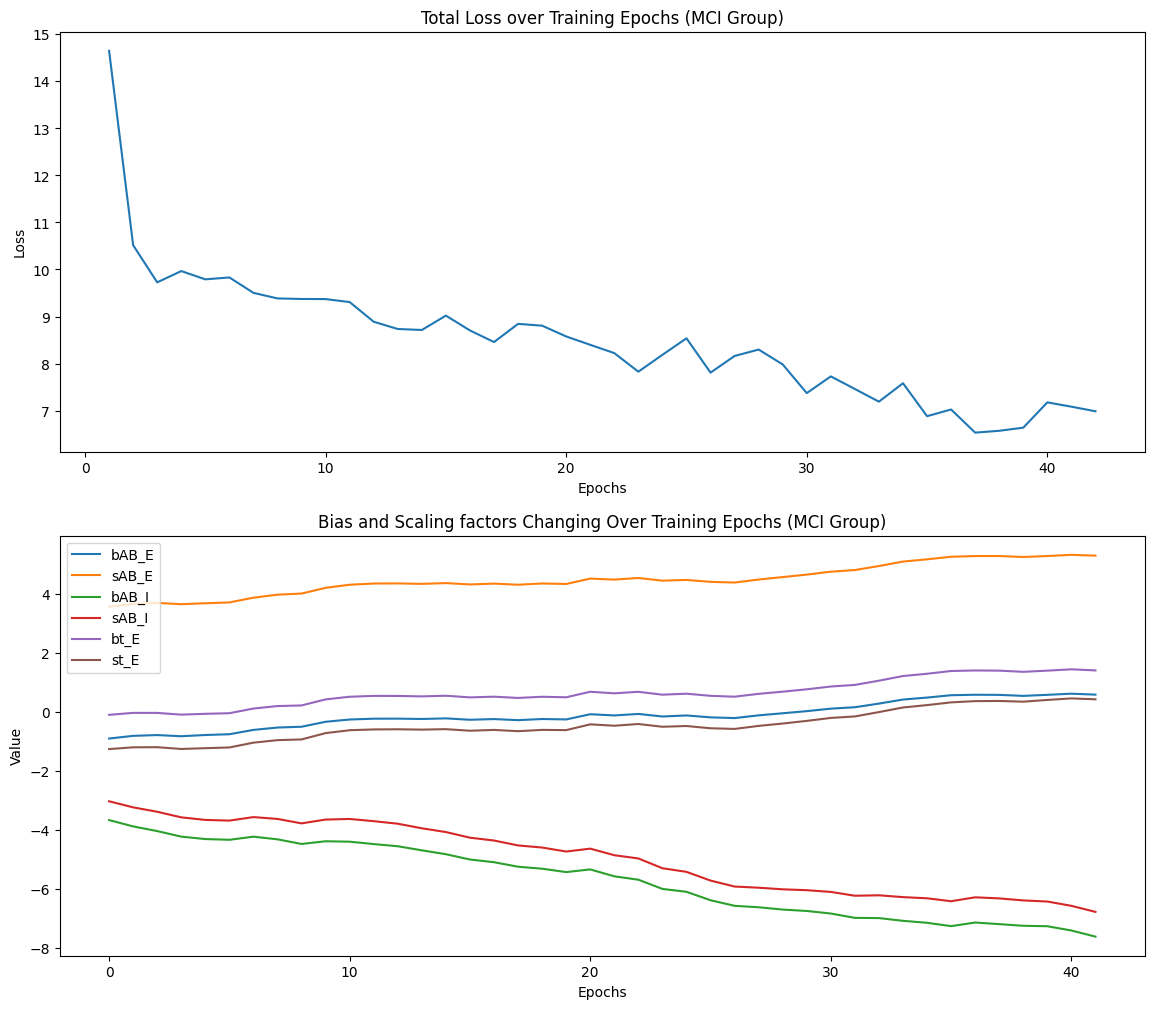

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Plots of loss over Training
ax[0].plot(np.arange(1,len(F.trainingStats.loss)+1), F.trainingStats.loss, label='loss')
ax[0].set_title(f'Total Loss over Training Epochs ({pgroup} Group)')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
# plt.show()

# %%
# Plots of parameters values over Training
ax[1].plot(F.trainingStats.fit_params['bAB_E'], label = "bAB_E")
ax[1].plot(F.trainingStats.fit_params['sAB_E'], label = "sAB_E")
ax[1].plot(F.trainingStats.fit_params['bAB_I'], label = "bAB_I")
ax[1].plot(F.trainingStats.fit_params['sAB_I'], label = "sAB_I")
ax[1].plot(F.trainingStats.fit_params['bt_E'], label = "bt_E")
ax[1].plot(F.trainingStats.fit_params['st_E'], label = "st_E")
ax[1].legend()
# ax[1].set_title("Excitatory ABeta bias factor Changing Over Training Epochs")
ax[1].set_title(f'Bias and Scaling factors Changing Over Training Epochs ({pgroup} Group)')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Value")

# plt.savefig(f'{pgroup}_abt_loss_curve.png')
plt.show()

Pearson Correlations:  0.6218216369526679


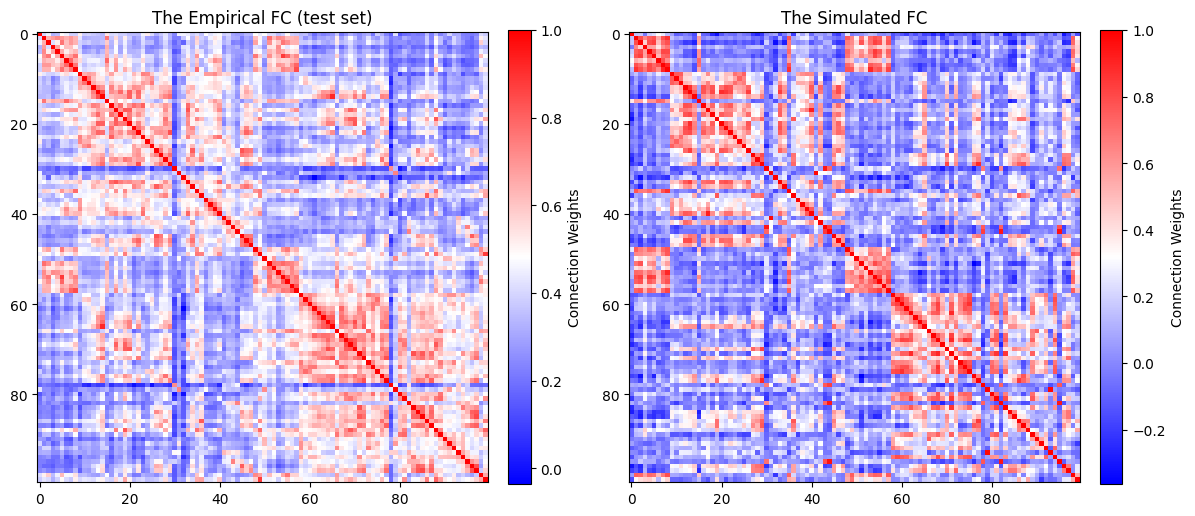

In [17]:
# Model Evaluation (with 20 window for warmup)
# ---------------------------------------------------

# Simulate the functional connectivity:
ts_sim, fc_sim = F.simulate(u =0, num_windows=int(ts_length/TPperWindow), base_window_num=20)

# average the evaluation scores across empirical data
fc_cor = F.evaluate(empFcs=[fc_emp_test], fc_sims=[fc_sim])

# -----------------------------------------------------------
# Plot the simulated FC + BOLD time series:

# Plot the FC and the test FC
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
im0 = ax[0].imshow(fc_emp_test, cmap='bwr')
ax[0].set_title('The Empirical FC (test set)')
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04, label='Connection Weights')

im1 = ax[1].imshow(fc_sim, cmap='bwr')
ax[1].set_title('The Simulated FC')
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04, label='Connection Weights')

# plt.savefig(f'{pgroup}_abt_simulated_fc.png')
plt.show()

In [ ]:
# Plot E I and simulated BOLD - separate lines for regions
emp_bold = test_data[1][:180].T
sim_bold = ts_sim
# Standardise times series
sim_bold = (sim_bold - sim_bold.mean(axis=0)) / sim_bold.std(axis=0)

# Select 10 unique random column indices
region_indices = np.random.choice(emp_bold.shape[0], 10, replace=False)
# # Select the columns using the random indices
subset_emp = emp_bold[region_indices, :]
subset_sim = sim_bold[region_indices, :]

k = 0

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

for idx, sub_array in enumerate(subset_emp):
    ax1.plot(sub_array + k, label=f'Region {region_indices[idx]}')
    k += 5

ax1.legend(loc='upper left')

# Add labels and title
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Signal Value')
ax1.set_title('Empirical BOLD Series')
# plt.show()

k = 0

for idx, sub_array in enumerate(subset_sim):
    ax2.plot(sub_array + k, label=f'Region {region_indices[idx]}')
    k += 5

# Add a legend to differentiate the plots
ax2.legend(loc='upper left')

# Add labels and title
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Signal Value')
ax2.set_title('Simulated BOLD Series')

# plt.savefig(f'{pgroup}_abt_model_bold.png')
plt.show()

In [ ]:
# Plot SC and fitted SC

fig, ax = plt.subplots(1, 2, figsize=(14, 8))
im0 = ax[0].imshow(sc, cmap='bwr', vmin = 0.0, vmax = 0.05)
ax[0].set_title('The empirical SC')
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04, label='Connection Weights')
im1 = ax[1].imshow(F.model.sc_fitted.detach().numpy(), cmap='bwr', vmin = 0.0, vmax = 0.05)
ax[1].set_title('The fitted SC')
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04, label='Connection Weights')
plt.show()

In [ ]:
# Plot E I and simulated BOLD
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].plot(F.lastRec['E'].npTS().T)
ax[0].set_title('Test: E')
ax[1].plot(F.lastRec['I'].npTS().T)
ax[1].set_title('Test: I')
ax[2].plot(F.lastRec['bold'].npTS().T)
ax[2].set_title('Test: BOLD')
plt.show()

### Plot the Empirical FC against Simulated FC 
Plot the lower triangles of each matrix against each other to replicate one of the plots from Griffith's paper

In [ ]:
# EDGE FC GRAPH
emp_fcs_edges = fc_emp_test.flatten()
sim_fcs_edges = fc_sim.flatten()

ax = sns.regplot(x=emp_fcs_edges, y=sim_fcs_edges, line_kws={'color':'red'}, scatter_kws={'s':3})
plt.text(0.75, -0.3, f"Pearson R: {fc_cor:.3f}", color='red')
plt.xlabel('Empirical FC')  # Replace 'X Axis Label' with the label for your x-axis
plt.ylabel('Simulated FC')  # Replace 'Y Axis Label' with the label for your y-axis
plt.title('Regional Predictions for Functional Connectivity (Edge FC)')   # Replace 'Scatter Plot' with the title for your plot

# plt.savefig(f'{pgroup}_abt_model_edgefc.png')

## Getting Prediction Statistics
Calculate average corr score and standard deviation

In [ ]:
# iterations = 20
# corrs = np.zeros(20)

# for i in range(iterations):
#     _, fc_sim = F.simulate(u =0, num_windows=int(ts_length/TPperWindow), base_window_num=20)

#     # average the evaluation scores across empirical data
#     fc_cor = F.evaluate(empFcs=[fc_emp_test], fc_sims=[fc_sim])
#     corrs[i] = fc_cor

# print('=================================================')
# print('Mean FC Corr Score: ', np.mean(corrs))
# print('Standard Dev for FC Corr Score: ', np.std(corrs))

## Results of Fitted Models

In [9]:
bAB_Es = []
sAB_Es = []
bAB_Is = []
sAB_Is = []
bt_Es = []
st_Es = []

groups = ['CN', 'MCI', 'AD']

for group in groups:
    bAB_Es.append(np.loadtxt(f'../data/fitted_params/bAB_E_{group}.txt'))
    sAB_Es.append(np.loadtxt(f'../data/fitted_params/sAB_E_{group}.txt'))
    bAB_Is.append(np.loadtxt(f'../data/fitted_params/bAB_I_{group}.txt'))
    sAB_Is.append(np.loadtxt(f'../data/fitted_params/sAB_I_{group}.txt'))
    bt_Es.append(np.loadtxt(f'../data/fitted_params/bt_E_{group}.txt'))
    st_Es.append(np.loadtxt(f'../data/fitted_params/st_E_{group}.txt'))

In [33]:
params = [bAB_Es, sAB_Es, bAB_Is, sAB_Is, bt_Es, st_Es]
names = ['bAB_E', 'sAB_E', 'bAB_I', 'sAB_I', 'bt_E', 'st_E']

for j in range(len(params)):
    print(names[j])
    for i in range(len(groups)):
        print('Group: ', groups[i])
        print('Mean:', np.mean(params[j][i]))
        print('Std dev: ', np.std(params[j][i]))

bAB_E
Group:  CN
Mean: 0.7911694161593914
Std dev:  0.42081117648445276
Group:  MCI
Mean: 1.850069819483906
Std dev:  0.9602800534119839
Group:  AD
Mean: -5.80915800333023
Std dev:  2.5753812908072407
sAB_E
Group:  CN
Mean: 2.9225407600402833
Std dev:  0.8339051170546496
Group:  MCI
Mean: 7.1746848821640015
Std dev:  1.3571794929174
Group:  AD
Mean: -3.8386839389801026
Std dev:  2.9994504132210165
bAB_I
Group:  CN
Mean: -3.8016204237937927
Std dev:  2.1653538818473725
Group:  MCI
Mean: -9.5482257604599
Std dev:  2.1451928865012464
Group:  AD
Mean: -9.083324790000916
Std dev:  1.2747937196261847
sAB_I
Group:  CN
Mean: -7.907003617286682
Std dev:  2.0645659042981666
Group:  MCI
Mean: -8.648366141319276
Std dev:  2.1722962737257734
Group:  AD
Mean: -11.654634284973145
Std dev:  1.2999673933951095
bt_E
Group:  CN
Mean: 0.6965176403522492
Std dev:  0.4274035433932658
Group:  MCI
Mean: 2.670088991522789
Std dev:  0.980024798855471
Group:  AD
Mean: -5.360099339485169
Std dev:  2.5669880003024

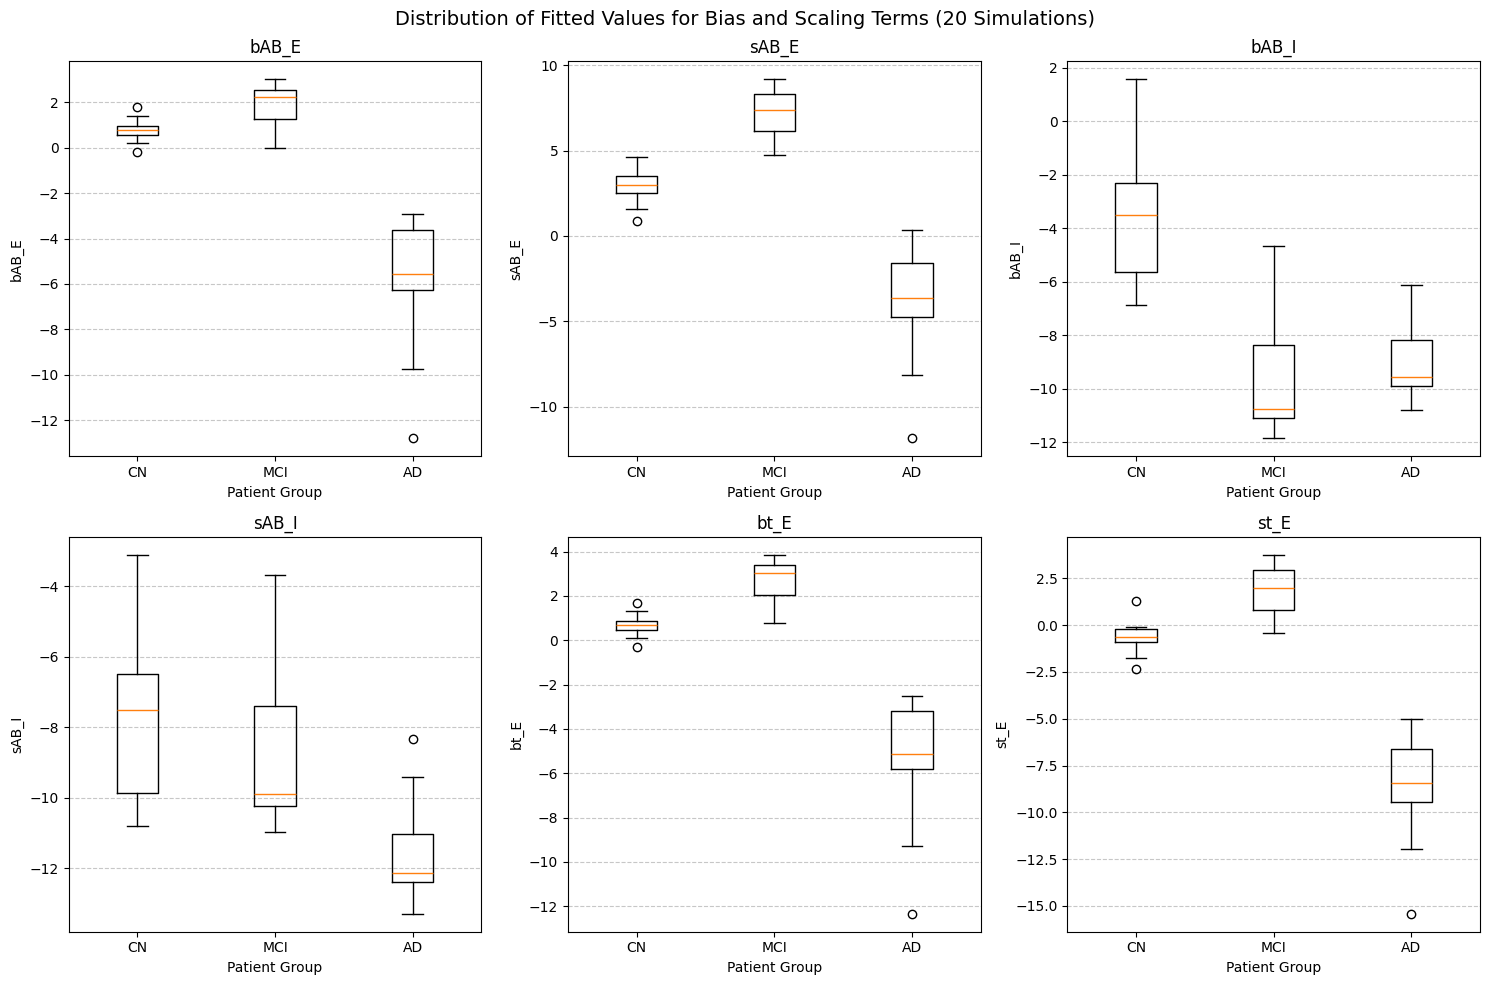

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Fitted Values for Bias and Scaling Terms (20 Simulations)', fontsize=14)

ax[0,0].boxplot(bAB_Es, labels=groups)
ax[0,0].set_title('bAB_E')
ax[0,0].set_xlabel('Patient Group')
ax[0,0].set_ylabel('bAB_E')
ax[0,0].grid(axis='y', linestyle='--', alpha=0.7)

ax[0,1].boxplot(sAB_Es, labels=groups)
ax[0,1].set_title('sAB_E')
ax[0,1].set_xlabel('Patient Group')
ax[0,1].set_ylabel('sAB_E')
ax[0,1].grid(axis='y', linestyle='--', alpha=0.7)

ax[0,2].boxplot(bAB_Is, labels=groups)
ax[0,2].set_title('bAB_I')
ax[0,2].set_xlabel('Patient Group')
ax[0,2].set_ylabel('bAB_I')
ax[0,2].grid(axis='y', linestyle='--', alpha=0.7)

ax[1,0].boxplot(sAB_Is, labels=groups)
ax[1,0].set_title('sAB_I')
ax[1,0].set_xlabel('Patient Group')
ax[1,0].set_ylabel('sAB_I')
ax[1,0].grid(axis='y', linestyle='--', alpha=0.7)

ax[1,1].boxplot(bt_Es, labels=groups)
ax[1,1].set_title('bt_E')
ax[1,1].set_xlabel('Patient Group')
ax[1,1].set_ylabel('bt_E')
ax[1,1].grid(axis='y', linestyle='--', alpha=0.7)

ax[1,2].boxplot(st_Es, labels=groups)
ax[1,2].set_title('st_E')
ax[1,2].set_xlabel('Patient Group')
ax[1,2].set_ylabel('st_E')
ax[1,2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('fitted_ab_params_boxplot.png')

plt.show()

## Saving + Loading Models

In [ ]:
# F.save('model/MCI_abt_model.pkl')

In [ ]:
# import pickle

# # Load the model from the file
# with open('model/AD_abt_model.pkl', 'rb') as f:
#     model = pickle.load(f)

In [ ]:
# model.evaluate(u = 0, empRecs = [data_mean], TPperWindow = TPperWindow, base_window_num = 20)